<a href="https://colab.research.google.com/github/vankhoa21991/cyberlab/blob/main/tutorial/week2_neuralnetwork/theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow

## Xây dựng một lớp

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD

In [2]:
# Xây dựng mô hình perceptron
class Perceptron(tf.keras.layers.Layer):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.W = self.add_weight("kernel",
                                  shape=[input_dim, output_dim])
    self.b = self.add_weight("bias",
                                  shape=[output_dim, 1])
  def call(self, inputs):
    z = tf.matmul(inputs, self.W)  + self.b
    output = tf.math.sigmoid(z)
    return output

In [3]:
layer = Perceptron(2, 3)

In [4]:
print([var.name for var in layer.trainable_variables])

['kernel:0', 'bias:0']


In [5]:
layer(tf.transpose(tf.zeros([2,3])))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.681839  , 0.681839  , 0.681839  ],
       [0.49031433, 0.49031433, 0.49031433],
       [0.40297902, 0.40297902, 0.40297902]], dtype=float32)>

In [6]:
print(layer.W, layer.b)

<tf.Variable 'kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[ 0.07664013,  0.14634264,  1.0235674 ],
       [-0.5219817 , -0.01764107, -0.09064865]], dtype=float32)> <tf.Variable 'bias:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.762236  ],
       [-0.03874755],
       [-0.3930679 ]], dtype=float32)>


In [7]:
layer_tf = Dense(3)
layer_tf(tf.transpose(tf.zeros([2,3])))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

## xây dựng một mô hình

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, input_shape=(2,)),
    tf.keras.layers.Dense(2)])

In [9]:
model(tf.transpose(tf.zeros([2,3])))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>

## Logistic regression 

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [34]:
np.random.seed(2)

X = np.array([[0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 1.75, 2.00, 2.25, 2.50, 
              2.75, 3.00, 3.25, 3.50, 4.00, 4.25, 4.50, 4.75, 5.00, 5.50]]).T
y = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]).T

x_train, y_train = tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)

In [48]:
class LogisticRegression(tf.Module):
    
  def __init__(self):
    self.built = False
    
  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [49]:
def log_loss(y_pred, y):
      # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

In [50]:
log_reg = LogisticRegression()

In [51]:
y_pred = log_reg(x_train, train=False)
y_pred.numpy()

array([0.60216224, 0.64939404, 0.6938691 , 0.7350046 , 0.77242553,
       0.8059572 , 0.8059572 , 0.8355998 , 0.8614923 , 0.8838735 ,
       0.90304524, 0.9193406 , 0.93310016, 0.94465375, 0.9623482 ,
       0.96901846, 0.9745382 , 0.9790958 , 0.982852  , 0.9884832 ],
      dtype=float32)

In [52]:
def predict_class(y_pred, thresh=0.5):
      # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [53]:
batch_size = 4
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)

In [54]:
# Set training parameters
epochs = 2000
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.874
Epoch: 100, Training log loss: 0.551
Epoch: 200, Training log loss: 0.509
Epoch: 300, Training log loss: 0.479
Epoch: 400, Training log loss: 0.460
Epoch: 500, Training log loss: 0.448
Epoch: 600, Training log loss: 0.437
Epoch: 700, Training log loss: 0.429
Epoch: 800, Training log loss: 0.424
Epoch: 900, Training log loss: 0.420
Epoch: 1000, Training log loss: 0.418
Epoch: 1100, Training log loss: 0.414
Epoch: 1200, Training log loss: 0.412
Epoch: 1300, Training log loss: 0.411
Epoch: 1400, Training log loss: 0.409
Epoch: 1500, Training log loss: 0.410
Epoch: 1600, Training log loss: 0.408
Epoch: 1700, Training log loss: 0.406
Epoch: 1800, Training log loss: 0.407
Epoch: 1900, Training log loss: 0.405


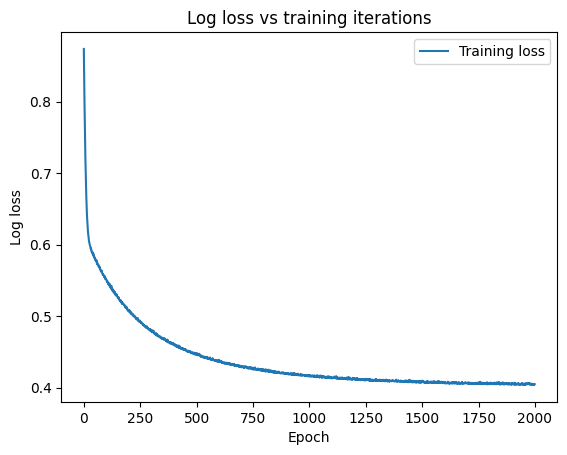

In [55]:
plt.plot(range(epochs), train_losses, label = "Training loss")
# plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

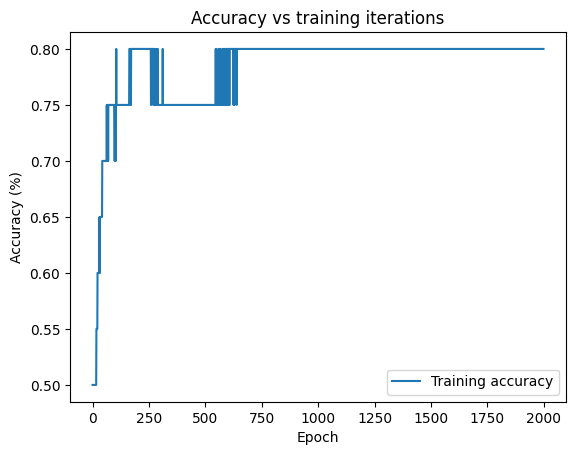

In [56]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
# plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [57]:
y_pred = log_reg(x_train, train=False)
print(y_pred.numpy(), y_train.numpy())

[0.05198646 0.07108787 0.09649333 0.12971032 0.17218289 0.22496781
 0.22496781 0.288299   0.36115092 0.44100487 0.5240321  0.60575193
 0.68195647 0.74952215 0.85354006 0.8905068  0.91902816 0.9406156
 0.95671874 0.9772986 ] [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.]


# Pytorch

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
# import matplotlib
from tqdm import tqdm
from sklearn.datasets import load_breast_cancer

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd

## 1. Logistic regression

In [ ]:
separable = False
while not separable:
    samples = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])


red_labels = np.zeros(len(red))
blue_labels = np.ones(len(blue))

labels = np.append(red_labels,blue_labels)
inputs = np.concatenate((red,blue),axis=0)

In [ ]:
X_train, X_test, y_train,  y_test = train_test_split(
    inputs, labels, test_size=0.33, random_state=42)

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [ ]:
epochs = 20000
input_dim = 2 # Two inputs x1 and x2 
output_dim = 1 # Two possible outputs
learning_rate = 0.01

model = LogisticRegression(input_dim,output_dim)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%10000==0:
        # calculate Accuracy
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")




Training Epochs:  52%|█████▏    | 10374/20000 [00:02<00:02, 4312.89it/s]

Iteration: 10000. 
Test - Loss: 0.03180432692170143. Accuracy: 99.39393939393939
Train -  Loss: 0.026539742946624756. Accuracy: 99.85074626865672



Training Epochs: 100%|██████████| 20000/20000 [00:04<00:00, 4212.14it/s]

Iteration: 20000. 
Test - Loss: 0.020546041429042816. Accuracy: 99.6969696969697
Train -  Loss: 0.016148626804351807. Accuracy: 99.85074626865672



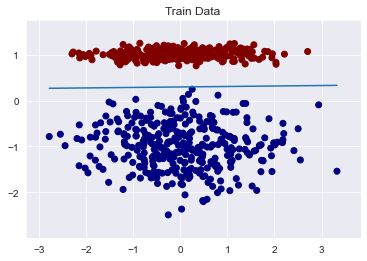

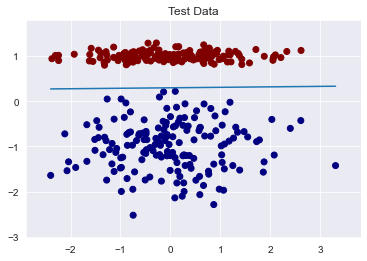

In [ ]:
def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    # plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    # plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
    plt.title(title)
    plt.show()


# Train Data
model_plot(model,X_train,y_train,'Train Data')

# Test Dataset Results
model_plot(model,X_test,y_test,'Test Data')

## 2. Multilayer perceptron

In [ ]:
# Loading dataset
data = load_breast_cancer()
# Dividing the dataset into target variable and features
X=data.data
y=data.target
print(y[:5])
print(len(X[0]))

[0 0 0 0 0]
30


In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = y.reshape(len(y), 1)
y_one_hot = onehot_encoder.fit_transform(integer_encoded)
print(y_one_hot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=20, random_state=1)

In [ ]:
learning_rate = 0.1
iterations = 5000
N = y_train.size
 
# Input features
input_size = 30
 
# Hidden layers 
hidden_size = 2
 
# Output layer
output_size = 2
 
results = pd.DataFrame(columns=["mse", "accuracy"])

In [ ]:
np.random.seed(10)
 
# Hidden layer
W1 = np.random.normal(scale=0.5, size=(input_size, hidden_size))   
 
# Output layer
W2 = np.random.normal(scale=0.5, size=(hidden_size , output_size)) 


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
 
def mean_squared_error(y_pred, y_true):
    return ((y_pred - y_true)**2).sum() / (2*y_pred.size)
     
def accuracy(y_pred, y_true):
    acc = y_pred.argmax(axis=1) == y_true.argmax(axis=1)
    return acc.mean()

In [ ]:
for itr in range(iterations):    
     
    # Implementing feedforward propagation on hidden layer
    Z1 = np.dot(X_train, W1)
    A1 = sigmoid(Z1)
 
    # Implementing feed forward propagation on output layer
    Z2 = np.dot(A1, W2)
    A2 = sigmoid(Z2)
    
    # Calculating the error
    mse = mean_squared_error(A2, y_train)
    acc = accuracy(A2, y_train)
    results=results.append({"mse":mse, "accuracy":acc},ignore_index=True )
     
    # Backpropagation phase
    E1 = A2 - y_train
    dW1 = E1 * A2 * (1 -A2)
 
    E2 = np.dot(dW1, W2.T)
    dW2 = E2 * A1 * (1 - A1)
 
     
    # Updating the weights
    W2_update = np.dot(A1.T, dW1) / N
    W1_update = np.dot(X_train.T, dW2) / N
 
    W2 = W2 - learning_rate * W2_update
    W1 = W1 - learning_rate * W1_update

C:\Users\vankh\AppData\Local\Temp/ipykernel_8008/1490148917.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({"mse":mse, "accuracy":acc},ignore_index=True )
C:\Users\vankh\AppData\Local\Temp/ipykernel_8008/1490148917.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({"mse":mse, "accuracy":acc},ignore_index=True )
C:\Users\vankh\AppData\Local\Temp/ipykernel_8008/1490148917.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({"mse":mse, "accuracy":acc},ignore_index=True )
C:\Users\vankh\AppData\Local\Temp/ipykernel_8008/1490148917.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

<AxesSubplot:title={'center':'Mean Squared Error'}>

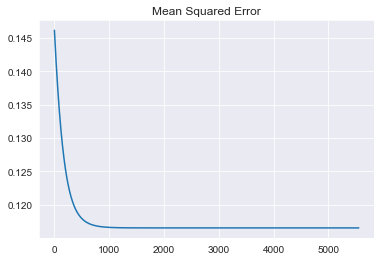

In [ ]:
results.mse.plot(title="Mean Squared Error")

<AxesSubplot:title={'center':'Accuracy'}>

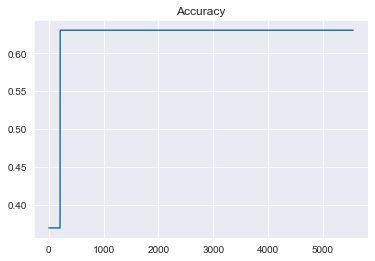

In [ ]:
results.accuracy.plot(title="Accuracy")

In [ ]:
Z1 = np.dot(X_test, W1)
A1 = sigmoid(Z1)
 
Z2 = np.dot(A1, W2)
A2 = sigmoid(Z2)
 
acc = accuracy(A2, y_test)
print("Accuracy: {}".format(acc))

Accuracy: 0.55
